# A Quantum Walk

$\textit{Group 1: Emil, Robin, Ege, Filippo, Netta \& Oxana}$

Performing a quantum random walk in Hilbert space:

$\mathcal{H} = \mathcal{H_c} \otimes \mathcal{H_p}$

In [72]:
#imports 
import numpy as np
import qiskit as q
import matplotlib.pyplot as plt

from qiskit.circuit.library.standard_gates import XGate, HGate
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from utils import *
from copy import deepcopy

## Walk on a line

For the first example, we are going to perform a walk on the line and test, if we get the expected distributions related to the coin operators and initial coin states.

For this particular case, we are going to use the following parameters:

 - Number of position space qubits: $N_p = 7$
 - Number of coin space qubits: $N_c = 1$
 - Number of steps for each sample: $T = 100$
 - Number of samples: $n = 1000$

In [73]:
#params:
Np = 7
Nc = 1
T = 100
n = 1024            

#init:
service = QiskitRuntimeService()
qc = q.QuantumCircuit(Np+Nc, Np) #number of qbits and number of cbits
it_Np = range(Np)
it_n = range(n)
it_T = range(T)


In [74]:
#If we want to run on IBM qpu, the following are available:
#service.backends()

In [75]:
#But, for our purposes, the sampler will do:
sampler = Sampler(service.least_busy(operational=True))

### Operators:

Coins:

$H = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}$, $X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}$ and $C_Y = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 & i \\ i & 1 \end{pmatrix}$

Forward step operator:

$S_F = \sum_{j=0}^{127} \ket{j+1}\bra{j}$

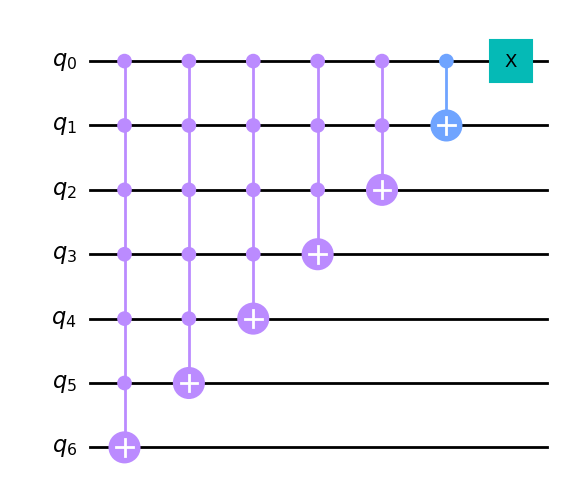

In [76]:
S_F = q.QuantumCircuit(Np)

for i in it_Np:
    current_qbit = Np-1-i
    if current_qbit == 0:
        g = XGate()
    else:
        g = XGate().control(num_ctrl_qubits=current_qbit)
    S_F.append(g, S_F.qregs[0][0:current_qbit+1])

S_F.draw("mpl")

Backward step operator:

$S_B = S_F^\dagger$

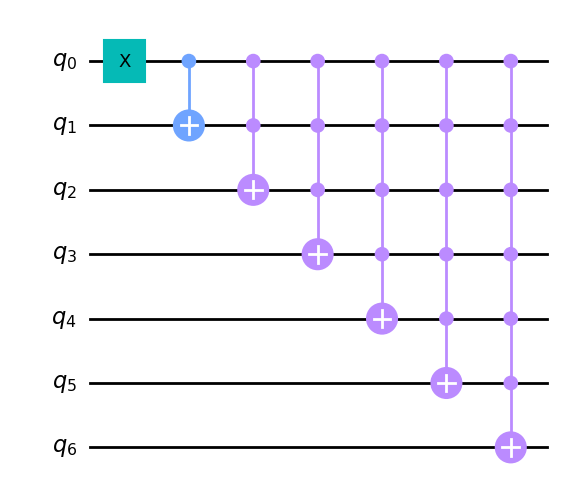

In [77]:
S_B = S_F.inverse()
S_B.draw("mpl")

The complete step operator:

$S = \ket{0}\bra{0}_c \otimes S_F + \ket{1}\bra{1}_c \otimes S_B$

We can now assemble the full Propagation operator:

$U = S \cdot (C \otimes \mathbb{1}_p)$

In [78]:
S_Fgate = S_F.to_gate().control(1)
S_Bgate = S_B.to_gate().control(1)

def propagator(num_qbits : int, coin_operator : q.circuit.Gate) -> q.circuit.Instruction:
    
    #The final building block: the propagate operator:
    U = q.QuantumCircuit(num_qbits)

    #Coin flip:
    U.append(coin_operator, U.qregs[0][0:1])

    #Controlled step forwards:
    U.append(S_Fgate, U.qregs[0])

    #Negate coin:
    U.append(XGate(), U.qregs[0][0:1])

    #Controlled step backwards:
    U.append(S_Bgate, U.qregs[0])

    #Negate coin:
    U.append(XGate(), U.qregs[0][0:1])

    return U.to_instruction()

## Running the walk:

In [79]:
def perform_walk(qc : q.QuantumCircuit, coin_operator : q.circuit.Gate, coin_state : list[float], position_state : int, H_input = False):
    
    U = propagator(Np+Nc, coin_operator)

    all_qbits = qc.qregs[0]
    position_qbits = qc.qregs[0][1:Np+1]

    #initialize states:
    qc.initialize(coin_state, 0)
    qc.initialize(position_state, position_qbits)
    
    #If instructed, Hadamard the input
    if H_input:
        qc.h(position_qbits)

    for t in it_T:
        #propagate
        qc.append(U, all_qbits)

    #measure:
    qc.measure(position_qbits)

### H coin

First, let's try the Hadamard coin with the following input states: ${\ket{0}, \ket{1}, \ket{+i}}$

In [80]:
coin_operator = HGate()

#initial position
#position_state = 63 is 0111111 in binary
position_inputs = {
    1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1
}

coin_inputs = {
    "0": [1., 0.],
    "1": [0., 1.],
    "+i": [1/np.sqrt(2), 1j/np.sqrt(2)]
}
results = {}

for input in coin_inputs:
    qc_instance = deepcopy(qc)
    perform_walk(qc_instance, coin_operator, coin_inputs[input])

TypeError: perform_walk() missing 1 required positional argument: 'position_state'

In [82]:
position_inputs = {
    1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1
}
for key in position_inputs:
    if position_inputs[key] == 1:
        qc.x(position_inputs[key])

qc.measure(qc.qregs[0][1:8], qc.cregs[0])
qc.draw()
job = sampler.run([qc])
result = job.result()
print(result)

RuntimeJobFailureError: "Unable to retrieve job result. UNEXPECTED PROGRAM INPUT PARAMETER 'CIRCUITS'."